# 라이브러리 설치

In [ ]:
!pip install langchain langchain-openai tiktoken openai faiss-cpu pypdf chromadb langchain_community datasets gradio==3.50.2

Google Drive 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


OpenAI_API_KEY

In [ ]:
import os
from google.colab import userdata
os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")

# 데이터 전처리

## 1. 데이터 수집

허깅페이스를 통해서 금융 용어 사전을 다운로드 진행
"시사경제용어사전"을 사용하며 500개 랜덤 선택

In [ ]:
from datasets import load_dataset, DatasetDict
import random

# 데이터 로드
dataset = load_dataset("aiqwe/FinShibainu", "qa")

# 데이터 구조 확인
print(dataset)

# 7:3 비율로 샘플링
def split_dataset(dataset, train_ratio=0.7):
    dataset = dataset.shuffle(seed=42)  # 데이터 섞기
    train_size = int(len(dataset) * train_ratio)
    train_data = dataset.select(range(train_size))
    test_data = dataset.select(range(train_size, len(dataset)))
    return train_data, test_data

# 각 데이터셋에 대해 샘플링 진행
dataset_splits = {split: split_dataset(dataset[split]) for split in dataset.keys()}

# 새로운 데이터셋 구성
new_dataset = DatasetDict({
    "train": dataset_splits["train"][0],
    "test": dataset_splits["train"][1]
})

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/6.05k [00:00<?, ?B/s]

train-00000-of-00006.parquet:   0%|          | 0.00/13.4M [00:00<?, ?B/s]

train-00001-of-00006.parquet:   0%|          | 0.00/13.2M [00:00<?, ?B/s]

train-00002-of-00006.parquet:   0%|          | 0.00/12.7M [00:00<?, ?B/s]

train-00003-of-00006.parquet:   0%|          | 0.00/13.0M [00:00<?, ?B/s]

train-00004-of-00006.parquet:   0%|          | 0.00/13.0M [00:00<?, ?B/s]

train-00005-of-00006.parquet:   0%|          | 0.00/13.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/44870 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['reference', 'question', 'answer_A', 'answer_B', 'preference', 'preference_desc', 'value', 'type'],
        num_rows: 44870
    })
})


In [ ]:
import pandas as pd

df_train = new_dataset["train"].to_pandas()
df_test = new_dataset["test"].to_pandas()

print(df_train.head(1))  # Train 데이터 확인
print(df_test.head(1))   # Test 데이터 확인

  reference                     question  \
0  지식경제용어사전  예치환거래은행에 대한 규제는 어떻게 이루어지나요?   

                                            answer_A  \
0  예치환거래은행은 외환 관련 규제 및 국제 거래 기준을 준수하며, 금융 거래의 안정성...   

                                            answer_B preference  \
0  예치환 거래은행(Deposit Bank) 혹은 예금을 취급하는 은행에 대한 규제는 ...          B   

                                     preference_desc  value type  
0  Answer B는 예치환거래은행에 대한 규제가 어떻게 이루어지는지를 구체적이고 체계...      5   qa  
  reference                    question  \
0  지식경제용어사전  신용장 거래에서 결제 조건은 어떻게 설정되나요?   

                                            answer_A  \
0  결제 조건은 신용장에서 명시되며, 이는 지급 보증, 인도 조건 및 지급 기한 등 다...   

                                            answer_B preference  \
0  신용장 거래에서 결제 조건은 거래 당사자 간의 합의에 따라 설정됩니다. 신용장은 수...          B   

                                     preference_desc  value type  
0  답변 B는 신용장 거래에서 결제 조건이 어떻게 설정되는지에 대한 보다 구체적이고 체...      4   qa  


In [ ]:
# 새로운 열 생성
df_train["question_answer_B"] = df_train["question"] + "\n" + df_train["answer_B"] # 임베딩을 위한 학습데이터
df_train["source"] = df_train["reference"] + "_" + df_train.index.astype(str) # 출처 표기를 위한 전처리
df_train.head(2)

,reference,question,answer_A,answer_B,preference,preference_desc,value,type,question_answer_B,source
0,지식경제용어사전,예치환거래은행에 대한 규제는 어떻게 이루어지나요?,"예치환거래은행은 외환 관련 규제 및 국제 거래 기준을 준수하며, 금융 거래의 안정성...",예치환 거래은행(Deposit Bank) 혹은 예금을 취급하는 은행에 대한 규제는 ...,B,Answer B는 예치환거래은행에 대한 규제가 어떻게 이루어지는지를 구체적이고 체계...,5,qa,예치환거래은행에 대한 규제는 어떻게 이루어지나요?\n예치환 거래은행(Deposit ...,지식경제용어사전_0
1,시사경제용어사전,시장지배적 지위의 남용행위란 무엇인가?,시장지배적 지위의 남용행위는 경쟁사업자에게 불리한 영향을 미치는 시장지배적 사업자의...,시장지배적 지위의 남용행위는 특정 기업이 자신이 시장에서 차지하고 있는 지배적인 위...,B,"답변 B는 시장지배적 지위의 남용행위에 대한 포괄적이고 구체적인 설명을 제공하며, ...",5,qa,시장지배적 지위의 남용행위란 무엇인가?\n시장지배적 지위의 남용행위는 특정 기업이 ...,시사경제용어사전_1


In [ ]:
df_train = df_train[df_train['reference'] == '시사경제용어사전'] # 시사경제용어사전 선택
df_top_500 = df_train.head(500) # 상단 500개 선택
df_train = df_top_500
df_train = df_train[['question_answer_B', 'source']]
df_train

,question_answer_B,source
1,시장지배적 지위의 남용행위란 무엇인가?\n시장지배적 지위의 남용행위는 특정 기업이 ...,시사경제용어사전_1
2,초등학교와 같은 사회기반시설은 민자사업을 통해 어떻게 공급되나요?\n초등학교와 같은...,시사경제용어사전_2
3,도매은행제도의 운영 효율성은 어떻게 설명될 수 있나요?\n도매은행제도(Wholesa...,시사경제용어사전_3
5,CFA 시험에서 컴파운드 옵션에 관련된 문제가 출제될 가능성이 높나요?\nCFA(공...,시사경제용어사전_5
7,투자위험보증사업의 주된 목적은 무엇인가?\n투자위험보증사업의 주된 목적은 투자자들에...,시사경제용어사전_7
...,...,...
751,"경제자유지수를 계산할 때 고려되는 요소들은 어떤 것들이며, 각 요소는 왜 중요한가?...",시사경제용어사전_751
752,하이브리드 카드와 신용카드의 차별성은?\n하이브리드 카드와 신용카드는 카드 기능에 ...,시사경제용어사전_752
753,이종통화라는 용어는 어떤 화폐들에 사용되나요?\n이종통화(異種通貨)라는 용어는 서로...,시사경제용어사전_753
754,환테크에서 정치적 요인이 환율에 미치는 영향은 무엇인가요?\n환테크(환율 기술적 분...,시사경제용어사전_754


<ipython-input-10-52ab7c88f352>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["question_answer_B_length"] = df_train["question_answer_B"].apply(len)


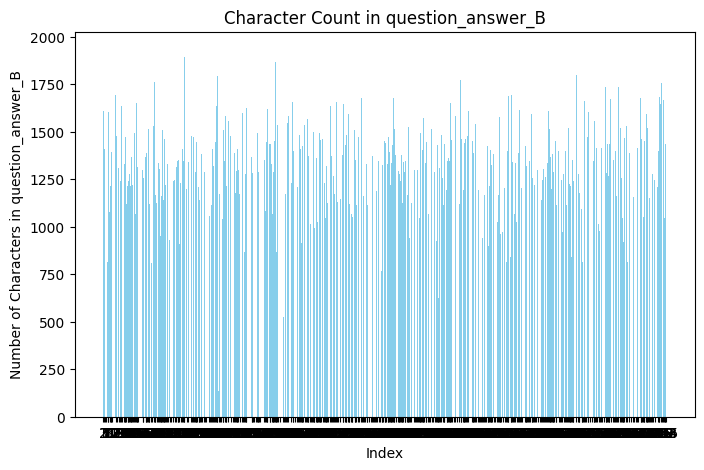

최대 길이: 1930 글자, 482 토큰
평균 길이: 1304 글자, 326 토큰
최소 길이: 134 글자, 33 토큰
------------------------------
적절 토큰 사이즈 : 512 토큰


In [ ]:
import matplotlib.pyplot as plt
import math

# question_answer_B 열의 각 행에서 문자열 길이 계산
df_train["question_answer_B_length"] = df_train["question_answer_B"].apply(len)

# 막대그래프 그리기
plt.figure(figsize=(8, 5))
plt.bar(df_train.index, df_train["question_answer_B_length"], color="skyblue", width=0.9)
plt.xlabel("Index")
plt.ylabel("Number of Characters in question_answer_B")
plt.title("Character Count in question_answer_B")
plt.xticks(df_train.index)

# 길이 통계 계산
max_length = df_train["question_answer_B_length"].max()
mean_length = df_train["question_answer_B_length"].mean()
min_length = df_train["question_answer_B_length"].min()

# 그래프 표시
plt.show()

# 통계 결과 출력
print(f"최대 길이: {max_length} 글자, {max_length // 4} 토큰")
print(f"평균 길이: {math.ceil(mean_length)} 글자, {math.ceil(mean_length) // 4} 토큰") # 올림
print(f"최소 길이: {min_length} 글자, {min_length // 4} 토큰")
print("-" * 30) # 구분선
print(f"적절 토큰 사이즈 : 512 토큰")


## 2. 토크나이저

* 한국어에 최적화된 토크나이저 사용
* 학습데이터 확인을 통해 512 토큰 기준으로 문장을 자름
* 데이터 검증 로직 포함

In [ ]:
from transformers import AutoTokenizer
import pandas as pd

# 사용할 토크나이저 선택 (한국어에 적합한 토크나이저 모델 선택)
tokenizer_name = "EbanLee/kobart-summary-v3"
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

max_token_length = 512 # 목표 최대 토큰 길이

# 텍스트를 토큰 ID로 변환하고, 최대 길이로 자르는 함수
def tokenize_and_truncate(text):
    tokens = tokenizer(text,
                       max_length=max_token_length,
                       truncation=True,
                       padding=False,
                       return_overflowing_tokens=True,
                       return_tensors=None)
    return tokens

# question_answer_B 열의 각 행에 대해 토큰화 및 자르기 적용
df_train["question_answer_B_tokenized"] = df_train["question_answer_B"].apply(tokenize_and_truncate)

# 토큰 ID 리스트를 텍스트 토큰 리스트로 변환
def get_text_tokens(tokenized_output):
    input_ids = tokenized_output['input_ids']
    text_tokens = [tokenizer.convert_ids_to_tokens(ids) for ids in input_ids] # 리스트 컴프리헨션으로 변경
    return text_tokens

df_train["question_answer_B_text_tokens"] = df_train["question_answer_B_tokenized"].apply(get_text_tokens)

# 문서가 잘렸는지 여부 확인 및 컬럼 추가
df_train["question_answer_B_truncated"] = df_train["question_answer_B_tokenized"].apply(lambda x: len(x['input_ids'][0]) == max_token_length if isinstance(x['input_ids'], list) else len(x['input_ids']) == max_token_length)


# 결과 확인 (토큰 ID 및 attention mask 출력)
print(df_train[["question_answer_B", "question_answer_B_text_tokens", "question_answer_B_truncated"]].head(10))

# 토큰 길이 확인 (자르기가 제대로 되었는지 확인)
df_train["question_answer_B_token_length_truncated"] = df_train["question_answer_B_tokenized"].apply(lambda x: len(x['input_ids'][0]) if isinstance(x['input_ids'], list) else len(x['input_ids']))
print("\n토큰 길이 통계 (최대 길이 512로 자른 후):")
print(f"최대 토큰 길이: {df_train['question_answer_B_token_length_truncated'].max()}")
print(f"평균 토큰 길이: {df_train['question_answer_B_token_length_truncated'].mean():.2f}")
print(f"최소 토큰 길이: {df_train['question_answer_B_token_length_truncated'].min()}")

tokenizer_config.json:   0%|          | 0.00/39.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.05M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/692 [00:00<?, ?B/s]

<ipython-input-14-1361f14b307f>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["question_answer_B_tokenized"] = df_train["question_answer_B"].apply(tokenize_and_truncate)


                                    question_answer_B  \
1   시장지배적 지위의 남용행위란 무엇인가?\n시장지배적 지위의 남용행위는 특정 기업이 ...   
2   초등학교와 같은 사회기반시설은 민자사업을 통해 어떻게 공급되나요?\n초등학교와 같은...   
3   도매은행제도의 운영 효율성은 어떻게 설명될 수 있나요?\n도매은행제도(Wholesa...   
5   CFA 시험에서 컴파운드 옵션에 관련된 문제가 출제될 가능성이 높나요?\nCFA(공...   
7   투자위험보증사업의 주된 목적은 무엇인가?\n투자위험보증사업의 주된 목적은 투자자들에...   
8   배출권거래제에서 거래되는 배출권의 가격은 어떤 원칙에 의해 결정됩니까?\n배출권거래...   
10  부도유예협약이 '부도방지협약'에서 '부도유예협약'으로 명칭이 변경된 이유는 무엇인가...   
11  투자은행이 설정하는 발행조건은 어떤 요소를 고려하나요?\n투자은행이 발행조건을 설정...   
12  현금배당과 주식배당의 차이점은 무엇인가요?\n현금배당과 주식배당은 기업이 주주에게 ...   
13  '88만원 세대'에서 88만원이라는 숫자가 도출된 계산 방식을 설명하시오.\n'88...   

                        question_answer_B_text_tokens  \
1   [[<s>, ▁시장, 지, 배, 적, ▁지, 위의, ▁남, 용, 행위, 란, ▁무엇...   
2   [[<s>, ▁초등학교, 와, ▁같은, ▁사회, 기반, 시설, 은, ▁민, 자, 사...   
3   [[<s>, ▁도, 매, 은행, 제, 도의, ▁운영, ▁효율, 성은, ▁어떻게, ▁...   
5   [[<s>, ▁C, FA, ▁시험, 에서, ▁컴, 파, 운드, ▁옵, 션, 에, ▁...   
7   [[<s>, ▁투자, 위험, 보증, 사업의, ▁주된, ▁목적은, ▁무엇인가, ?\n...   
8   [[<s>, ▁배출, 권, 거래, 제, 에서, 

<ipython-input-14-1361f14b307f>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["question_answer_B_text_tokens"] = df_train["question_answer_B_tokenized"].apply(get_text_tokens)
<ipython-input-14-1361f14b307f>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["question_answer_B_truncated"] = df_train["question_answer_B_tokenized"].apply(lambda x: len(x['input_ids'][0]) == max_token_length if isinstance(x['input_ids'], list) else len(x['input_ids']) == max_token_length)
<ipython-input-14-

# 임베딩

## 1.   bge-m3 모델 (한국어 및 금융용어 학습 모델)



#### 1-1 임베딩 모델 저장

In [ ]:
import pandas as pd
from tqdm import tqdm
from langchain.schema import Document
from langchain.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings

# # Document 객체로 변환
documents = [
    Document(
        page_content=row["question_answer_B"],
        metadata={"source": row["source"]}
    )
    for _, row in df_train.iterrows()
]

# 배치 크기 설정
batch_size = 500
batched_documents = [
    documents[i:i+batch_size] for i in range(0, len(documents), batch_size)
]

# Hugging Face Embedding 모델 설정
model_name = "seongil-dn/bge-m3-kor-retrieval-451949-bs64-finance-50"

# -------------------------------
#"max_position_embeddings": 8194
#"vocab_size": 250002
# -------------------------------

model_kwargs = {'device': 'cuda'}
encode_kwargs = {'normalize_embeddings': False}
embedding = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

# **Chroma DB 초기화**
persist_directory = "/content/drive/MyDrive/vectorDB"
vectordb = Chroma(persist_directory=persist_directory, embedding_function=embedding)

# 배치별로 임베딩 생성 및 Chroma DB에 추가 (add_documents 사용)
for batch in tqdm(batched_documents, desc="Embedding Progress", unit="batch"):
    vectordb.add_documents(documents=batch)

# Chroma DB 저장
vectordb.persist()
vectordb = None  # 메모리에서 vectordb 객체 삭제

print(f"Embedding 완료 및 Chroma DB 저장 완료! {persist_directory} 에 저장됨")

<ipython-input-15-496c34731679>:32: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding = HuggingFaceEmbeddings(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/201 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/39.9k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/741 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

<ipython-input-15-496c34731679>:40: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectordb = Chroma(persist_directory=persist_directory, embedding_function=embedding)
Embedding Progress: 100%|██████████| 1/1 [01:15<00:00, 75.64s/batch]

Embedding 완료 및 Chroma DB 저장 완료! /content/drive/MyDrive/vectorDB 에 저장됨



<ipython-input-15-496c34731679>:47: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  vectordb.persist()


#### 1-2 Colab 임베딩 모델 불러오기

In [ ]:
from langchain.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings

# 임베딩 모델 설정 (저장 시 사용했던 모델과 동일해야 함)
model_name = "seongil-dn/bge-m3-kor-retrieval-451949-bs64-finance-50"

# -------------------------------
#"max_position_embeddings": 8194
#"vocab_size": 250002
# -------------------------------

model_kwargs = {'device': 'cuda'} # GPU 사용 가능하면 'cuda', CPU 사용 시 'cpu'
encode_kwargs = {'normalize_embeddings': False}
embedding = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

# 저장된 Chroma DB 로드 (persist_directory 경로 지정)
persist_directory = "/content/drive/MyDrive/vectorDB"
loaded_vectordb = Chroma(persist_directory=persist_directory, embedding_function=embedding)

print("Chroma DB 로드 완료!")

Chroma DB 로드 완료!


### 1-3 검색 및 결과 확인

In [ ]:
# 6. 벡터 검색 및 결과 확인
query = "콜금리와 밀접한 관련이 있는 단기금리는 어떤게 있어" # 검색 질문
k = 3 # 상위 k개 유사 문서 검색

results_with_scores = loaded_vectordb.similarity_search_with_score(query, k=k) # 유사도 검색

print(f"\n---[검색 결과]---")
print(f"검색 질문: {query}")
for i, (doc, score) in enumerate(results_with_scores): # 검색 결과 순회
    print(f"\n---[유사 문서 {i+1}]---")
    print(f"내용: {doc.page_content}") # 문서 내용
    print(f"유사도 점수: {score}") # 유사도 점수
    print(f"출처: {doc.metadata['source']}") # 문서 출처
    print("---[검색 결과 끝]---")


---[검색 결과]---
검색 질문: 콜금리와 밀접한 관련이 있는 단기금리는 어떤게 있어

---[유사 문서 1]---
내용: 콜금리와 밀접한 관련이 있는 단기금리는 무엇이 있나요?
콜금리와 밀접한 관련이 있는 단기금리는 주로 다음과 같습니다:

1. **기타 단기금리**: 콜금리와 유사한 방식으로 결정되는 단기금리로는 
   - **91일 만기 국채 수익률**: 정부가 발행하는 단기 국채의 수익률로, 일반적으로 콜금리가 상승하면 이자율도 상승하는 경향이 있습니다.
   - **단기금융증권 금리 (CP)**: 기업이 단기 자금을 조달하기 위해 발행하는 상업어음(CP)의 금리로, 콜금리와 밀접하게 연관되어 있습니다.
   - **증권사 RP 금리**: 증권사가 발행하는 환매조건부채권의 금리로, 시장 상황에 따라 콜금리와 유사한 방향으로 변동됩니다.

2. **연구와 증권 거래소의 금리**: 거래소와 관련된 단기 금융 상품의 금리도 콜금리와 상관관계를 가집니다. 
   - **CD(양도성예금증서) 금리**: 은행이 발행하는 양도성 예금 증서의 금리도 일반적으로 콜금리와 연동되는 경향이 있습니다.

3. **잠재적 변동성**: 단기금리는 시장의 유동성에 따라 달라지기 때문에, 글로벌 경제상황, 중앙은행의 통화정책, 그리고 경제지표의 발표에 따라 민감하게 반응합니다. 따라서 이를 통해 단기금리가 콜금리와 어떻게 상호작용하는지를 이해할 수 있습니다.

4. **시장 예측금리 (Forward Rate)**: 미래의 단기금리를 예측하는 금리로, 예를 들어 3개월 후의 금리와 같은 것이며, 콜금리의 변화가 이 예측에 직접적인 영향을 미칩니다.

결론적으로, 콜금리는 상호작용하는 다양한 단기금리에 영향을 미치며, 이는 금융시장의 유동성과 투자자의 행동을 반영하여 끊임없이 변화합니다. 따라서 콜금리와 상관된 단기금리를 살펴보는 것은 금융 및 경제 동향을 이해하는 데 중요한 요소가 됩니다.
유사도 점수: 0.7796501517295837
출처: 시사경제용어사전_45
---[검색

### 1-4 벡터 검색 및 결과 확인

#### 유사도 점수 기준이하(1.0)인 경우 별도로 표기


###1.   검색 결과의 신뢰성 향상

* 유사도 점수가 낮은 결과를 필터링하거나 별도 표기하여 부정확한 정보 제공을 방지
* 신뢰도가 낮은 검색 결과를 구분해 잘못된 정보 맹신을 줄이고 사용자 경험 개선

* "정확한 결과를 찾지 못했습니다."와 같은 안내로 사용자 기대 조정 가능


### 2.   검색 결과 품질 및 UX 개선

* 관련성이 낮은 문서를 제거하여 보다 정밀한 검색 결과 제공
* 검색 결과 과포화 방지 → 사용자가 원하는 정보를 빠르게 찾을 확률 증가
* 불확실한 검색 결과를 별도 표기해 사용자가 보완 검색을 고려하도록 유도













In [ ]:
# 6. 벡터 검색 및 결과 확인
query = "하이브리드 카드와 신용카드는 동일한가요, 아니면 차이가 있나요?" # 검색 질문
k = 5 # 상위 k개 유사 문서 검색

results_with_scores = loaded_vectordb.similarity_search_with_score(query, k=k) # 유사도 검색

print(f"\n---[검색 결과]---")
print(f"검색 질문: {query}")

threshold = 1.0 # 유사도 점수 기준값
print(f"유사도 점수 기준값: {threshold} 이상인 문서는 '-------' 아래에 표시됩니다.")

below_threshold_docs = [] # 기준값 미만 문서 저장 리스트
above_threshold_docs = [] # 기준값 이상 문서 저장 리스트

for i, (doc, score) in enumerate(results_with_scores): # 검색 결과 순회
    if score < threshold: # 유사도 점수가 기준값 미만
        below_threshold_docs.append((doc, score)) # 기준값 미만 문서 리스트에 추가
    else: # 유사도 점수가 기준값 이상 (>= threshold)
        above_threshold_docs.append((doc, score)) # 기준값 이상 문서 리스트에 추가

# 기준값 미만 문서 출력 (있는 경우에만 섹션 제목 출력)
if below_threshold_docs:
    print(f"\n---[기준값 미만 (유사도 점수 < {threshold})]---")
    for i, (doc, score) in enumerate(below_threshold_docs):
        print(f"\n---[유사 문서 {i+1}]---")
        print(f"내용: {doc.page_content}")
        print(f"유사도 점수: {score}")
        print(f"출처: {doc.metadata['source']}")

# 구분선 및 기준값 이상 문서 출력 (있는 경우에만 섹션 제목 출력)
if above_threshold_docs:
    print(f"\n-------[기준값 이상 (유사도 점수 >= {threshold})]-------") # 구분선 및 섹션 제목
    for i, (doc, score) in enumerate(above_threshold_docs):
        print(f"\n---[유사 문서 {i+1}]---")
        print(f"내용: {doc.page_content}")
        print(f"유사도 점수: {score}")
        print(f"출처: {doc.metadata['source']}")

print("---[검색 결과 끝]---")


---[검색 결과]---
검색 질문: 하이브리드 카드와 신용카드는 동일한가요, 아니면 차이가 있나요?
유사도 점수 기준값: 1.0 이상인 문서는 '-------' 아래에 표시됩니다.

---[기준값 미만 (유사도 점수 < 1.0)]---

---[유사 문서 1]---
내용: 하이브리드 카드와 신용카드의 차별성은?
하이브리드 카드와 신용카드는 카드 기능에 따라 차별성이 있습니다. 아래에서 이 두 가지 카드의 주요 차이점을 정리해 보겠습니다.

### 1. 기본 개념
- **신용카드**: 신용카드는 금융 기관이 발급하여 사용자가 일정 한도 내에서 돈을 빌려 쓰고, 이후에 그 금액을 담보 없이 상환하는 형태의 카드입니다. 기본적으로 신용 카드는 지불을 즉시 하지 않고, 일정 기간 후에 청구서를 통해 결제하는 시스템입니다.

- **하이브리드 카드**: 하이브리드 카드는 신용카드와 체크카드의 기능을 결합한 카드입니다. 보통 하이브리드 카드는 사용자가 자신의 계좌에서 돈을 직접 인출하는 체크카드 기능과, 신용한도 내에서 돈을 빌려 사용할 수 있는 신용카드 기능을 동시에 제공합니다.

### 2. 결제 방식
- **신용카드**: 사용자가 카드를 이용해 상품이나 서비스를 구매하면, 그 금액은 신용 카드사의 계좌에서 결제됩니다. 사용자는 카드사에게 매달 청구된 금액을 전부 또는 일부 상환할 수 있으며, 이 때 신용한도 내에서 이용했던 금액에 대해 이자가 발생할 수 있습니다.

- **하이브리드 카드**: 하이브리드 카드는 사용자가 자신의 계좌와 신용한도를 결합하여 사용할 수 있습니다. 체크카드 기능으로는 계좌 잔액을 초과하여 사용할 수 없지만, 신용카드 기능을 이용하면 신용 한도 내에서 추가적으로 결제할 수 있습니다. 즉, 본인이 소유한 자산을 바탕으로 금융 서비스를 받을 수 있습니다.

### 3. 연회비 및 비용
- **신용카드**: 많은 신용카드는 연회비가 있습니다. 이 연회비는 카드의 종류에 따라 다르며, 다양한 혜택(포인트 적립, 보험 등)을 고려해 결정됩니다. 

#### 2. OPEN AI API 사용
##### 유사어 사전을 구축해 검색 결과의 정확도를 높혔다.
###### 1. 검색 정확도 및 사용자 경험(UX)개선
* 유사어 사전을 활용하여 검색어 변형(동의어, 철자 오류, 약어 등)을 자동 반영, 검색 Recall 증가
* 사용자가 정확한 키워드를 몰라도 원하는 결과를 쉽게 찾을 수 있도록 지원, 접근성 향상
* 예: "자동차" ≈ "승용차", "휴대폰" ≈ "스마트폰" 등으로 확장하여 보다 자연스러운 검색 가능

###### 2. 도메인 맞춤 검색 최적화
* 의료, 금융, 법률 등 특정 산업에서 전문 용어나 약어를 자동 변환하여 검색 정확도 증가
* "금리" ≈ "이자", "주택담보대출" ≈ "모기지" 등 도메인 특화 검색 가능








In [ ]:
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
from langchain.schema import Document
from langchain.embeddings import OpenAIEmbeddings
import pandas as pd
import numpy as np

# 1. 유사어 사전 구축
economic_terms = {
    "금리": ["이자", "이율"],
    "대출": ["융자", "차입"],
    "예금": ["적금", "저축"],
    "주식": ["증권", "스톡"],
    "채권": ["국채", "회사채"],
    "물가": ["인플레이션", "가격 상승"],
    "환율": ["외환 가격", "통화 가치"],
    "자산": ["재산", "부동산"],
    "투자": ["자본 운용", "펀딩"],
    "소득": ["수입", "임금"]
}
synonym_dict = economic_terms

# 2. 쿼리 확장 함수
def expand_query_with_synonyms(query, synonym_dict):
    expanded_query = query
    for main_word, synonyms in synonym_dict.items():
        for synonym in synonyms:
            if synonym in query:
                expanded_query += f" OR {query.replace(synonym, main_word)}"
    return expanded_query

# DataFrame에서 Langchain Document 객체 생성
texts = [Document(page_content=str(row["question_answer_B"]), metadata={"source": row["source"]})
         for _, row in df_train.iterrows()]
documents = texts

# DataFrame을 Document 목록으로 변환
from langchain.schema import Document

texts = [Document(page_content=str(row["question_answer_B"]), metadata={"source": row["source"]})
         for _, row in df_train.iterrows()]

embedding = OpenAIEmbeddings()

vectordb = Chroma.from_documents(
    documents=texts,
    embedding=embedding)

<ipython-input-33-d1e8447e4463>:45: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embedding = OpenAIEmbeddings()


In [ ]:
# 벡터DB의 개수 확인
vectordb._collection.count()

500

In [ ]:
# 벡터DB의 요소 확인
for key in vectordb._collection.get():
  print(key)

ids
embeddings
documents
uris
data
metadatas
included


In [ ]:
# 문서 로드
documents = vectordb._collection.get()['documents']
print('문서의 개수 :', len(documents))
print('-' * 100)
print('첫번째 문서 출력 :', documents[0])

문서의 개수 : 500
----------------------------------------------------------------------------------------------------
첫번째 문서 출력 : 시장지배적 지위의 남용행위란 무엇인가?
시장지배적 지위의 남용행위는 특정 기업이 자신이 시장에서 차지하고 있는 지배적인 위치를 활용하여 경쟁을 저해하거나 소비자에게 피해를 주는 행동을 의미합니다. 이는 일반적으로 공정거래법과 관련된 규제의 대상이 되며, 각국의 경쟁법에서 그 형태와 규제가 다를 수 있지만, 기본적인 개념은 비슷합니다.

### 1. **시장지배적 지위란?**  
시장지배적 지위는 한 기업이 특정 시장에서 할인된 가격, 제품의 질, 서비스 수준 등을 통해 경쟁업체보다 우위를 점하고 있는 상황을 말합니다. 일반적으로 시장 점유율이 50% 이상인 경우 지배적 지위가 있다고 평가되지만, 그 외에도 가격 설정 능력이나 시장 진입 장벽 등의 여러 요소가 고려됩니다.

### 2. **남용의 형태**  
시장지배적 지위의 남용행위는 여러 형태로 나타날 수 있으며, 대표적으로 다음과 같은 경우가 있습니다:

- **가격 차별**: 동일 제품에 대해 고객이나 지역에 따라 다르게 가격을 설정하여 일부 고객에게 불리한 가격을 부과하거나 경쟁업체와의 경쟁을 제한하는 경우.
  
- **제한적 거래**: 공급업체나 유통업체와의 계약에서 독점적인 거래를 강요하거나, 경쟁업체의 거래를 방해하는 경우. 이는 시장 접근을 어렵게 하여 경쟁을 감소시킵니다.
  
- **낙후된 서비스**: 유통 채널 통제 등을 통해 다른 기업의 제품이나 서비스의 시장 진입을 어렵게 하거나 직접적인 경쟁을 제한하는 경우.
  
- **이런 형태의 상품 또는 서비스의 강제로 거래**: 필수적인 상품이나 서비스를 제공하는 기업이 고객에게 다른 상품이나 서비스의 구매를 강제하는 경우.

### 3. **법적 규제와 제재**  
시장지배적 지위의 남용행위는 각국의 경쟁당국에 의해 

In [ ]:
# 유사도가 높은 문서 2개만 추출. k = 2
retriever = vectordb.as_retriever(search_kwargs={"k": 2})

In [ ]:
# 벡터DB에서 데이터 가져오기
vector_data = vectordb._collection.get()

# 'embeddings' 데이터 추출 (딕셔너리에서 'embeddings' 키의 값을 가져옴)
embeddings = vector_data['embeddings']

# 'embeddings'가 리스트인지 확인 (안전하게 처리하기 위해)
if isinstance(embeddings, list) and embeddings: # 리스트이고 비어있지 않은지 확인
  print('첫번째 유사 문서 임베딩 :', embeddings[0])
else:
  print("embeddings 데이터를 찾을 수 없거나 비어 있습니다.")

ids = vector_data['ids']
documents = vector_data['documents']
metadatas = vector_data['metadatas']
data = vector_data['data']
embeddings = vector_data['embeddings']

# 첫 번째 문서 내용 출력
if isinstance(documents, list) and documents:
    print('첫번째 문서 내용 :', documents[0])
    print('첫번째 문서 출처 :', metadatas[0])

embeddings 데이터를 찾을 수 없거나 비어 있습니다.
첫번째 문서 내용 : 시장지배적 지위의 남용행위란 무엇인가?
시장지배적 지위의 남용행위는 특정 기업이 자신이 시장에서 차지하고 있는 지배적인 위치를 활용하여 경쟁을 저해하거나 소비자에게 피해를 주는 행동을 의미합니다. 이는 일반적으로 공정거래법과 관련된 규제의 대상이 되며, 각국의 경쟁법에서 그 형태와 규제가 다를 수 있지만, 기본적인 개념은 비슷합니다.

### 1. **시장지배적 지위란?**  
시장지배적 지위는 한 기업이 특정 시장에서 할인된 가격, 제품의 질, 서비스 수준 등을 통해 경쟁업체보다 우위를 점하고 있는 상황을 말합니다. 일반적으로 시장 점유율이 50% 이상인 경우 지배적 지위가 있다고 평가되지만, 그 외에도 가격 설정 능력이나 시장 진입 장벽 등의 여러 요소가 고려됩니다.

### 2. **남용의 형태**  
시장지배적 지위의 남용행위는 여러 형태로 나타날 수 있으며, 대표적으로 다음과 같은 경우가 있습니다:

- **가격 차별**: 동일 제품에 대해 고객이나 지역에 따라 다르게 가격을 설정하여 일부 고객에게 불리한 가격을 부과하거나 경쟁업체와의 경쟁을 제한하는 경우.
  
- **제한적 거래**: 공급업체나 유통업체와의 계약에서 독점적인 거래를 강요하거나, 경쟁업체의 거래를 방해하는 경우. 이는 시장 접근을 어렵게 하여 경쟁을 감소시킵니다.
  
- **낙후된 서비스**: 유통 채널 통제 등을 통해 다른 기업의 제품이나 서비스의 시장 진입을 어렵게 하거나 직접적인 경쟁을 제한하는 경우.
  
- **이런 형태의 상품 또는 서비스의 강제로 거래**: 필수적인 상품이나 서비스를 제공하는 기업이 고객에게 다른 상품이나 서비스의 구매를 강제하는 경우.

### 3. **법적 규제와 제재**  
시장지배적 지위의 남용행위는 각국의 경쟁당국에 의해 조사 및 규제될 수 있습니다. 예를 들어, 한국의 경우 공정거래위원회가 이러한 남용행위를 감시하는 역할을 하고 있으며, 위반 기업에는 과징금 부

In [ ]:
docs = retriever.get_relevant_documents("콜금리와 밀접한 관련이 있는 단기금리는 어떤게 있어")
print('유사 문서 개수 :', len(docs))
print('--' * 20)
print('첫번째 유사 문서 :', docs[0])
print('----------------------------------------------')
print('두번째 유사 문서 :', docs[1])

유사 문서 개수 : 2
----------------------------------------
첫번째 유사 문서 : page_content='콜금리와 밀접한 관련이 있는 단기금리는 무엇이 있나요?
콜금리와 밀접한 관련이 있는 단기금리는 주로 다음과 같습니다:

1. **기타 단기금리**: 콜금리와 유사한 방식으로 결정되는 단기금리로는 
   - **91일 만기 국채 수익률**: 정부가 발행하는 단기 국채의 수익률로, 일반적으로 콜금리가 상승하면 이자율도 상승하는 경향이 있습니다.
   - **단기금융증권 금리 (CP)**: 기업이 단기 자금을 조달하기 위해 발행하는 상업어음(CP)의 금리로, 콜금리와 밀접하게 연관되어 있습니다.
   - **증권사 RP 금리**: 증권사가 발행하는 환매조건부채권의 금리로, 시장 상황에 따라 콜금리와 유사한 방향으로 변동됩니다.

2. **연구와 증권 거래소의 금리**: 거래소와 관련된 단기 금융 상품의 금리도 콜금리와 상관관계를 가집니다. 
   - **CD(양도성예금증서) 금리**: 은행이 발행하는 양도성 예금 증서의 금리도 일반적으로 콜금리와 연동되는 경향이 있습니다.

3. **잠재적 변동성**: 단기금리는 시장의 유동성에 따라 달라지기 때문에, 글로벌 경제상황, 중앙은행의 통화정책, 그리고 경제지표의 발표에 따라 민감하게 반응합니다. 따라서 이를 통해 단기금리가 콜금리와 어떻게 상호작용하는지를 이해할 수 있습니다.

4. **시장 예측금리 (Forward Rate)**: 미래의 단기금리를 예측하는 금리로, 예를 들어 3개월 후의 금리와 같은 것이며, 콜금리의 변화가 이 예측에 직접적인 영향을 미칩니다.

결론적으로, 콜금리는 상호작용하는 다양한 단기금리에 영향을 미치며, 이는 금융시장의 유동성과 투자자의 행동을 반영하여 끊임없이 변화합니다. 따라서 콜금리와 상관된 단기금리를 살펴보는 것은 금융 및 경제 동향을 이해하는 데 중요한 요소가 됩니다.' metadata={'source': '시사경제용어사전_45'}
-----

In [ ]:
query_embedding = embedding.embed_query("콜금리와 밀접한 관련이 있는 단기금리는 어떤게 있어")
print('유사 문서 개수 :', len(docs))
print('--' * 20)
print('첫번째 유사 문서 :', docs[0])
print('첫번째 유사 문서 :', metadatas[0])
print('----------------------------------------------')
print('두번째 유사 문서 :', docs[1])
print('두번째 유사 문서 :', metadatas[1])

유사 문서 개수 : 2
----------------------------------------
첫번째 유사 문서 : page_content='콜금리와 밀접한 관련이 있는 단기금리는 무엇이 있나요?
콜금리와 밀접한 관련이 있는 단기금리는 주로 다음과 같습니다:

1. **기타 단기금리**: 콜금리와 유사한 방식으로 결정되는 단기금리로는 
   - **91일 만기 국채 수익률**: 정부가 발행하는 단기 국채의 수익률로, 일반적으로 콜금리가 상승하면 이자율도 상승하는 경향이 있습니다.
   - **단기금융증권 금리 (CP)**: 기업이 단기 자금을 조달하기 위해 발행하는 상업어음(CP)의 금리로, 콜금리와 밀접하게 연관되어 있습니다.
   - **증권사 RP 금리**: 증권사가 발행하는 환매조건부채권의 금리로, 시장 상황에 따라 콜금리와 유사한 방향으로 변동됩니다.

2. **연구와 증권 거래소의 금리**: 거래소와 관련된 단기 금융 상품의 금리도 콜금리와 상관관계를 가집니다. 
   - **CD(양도성예금증서) 금리**: 은행이 발행하는 양도성 예금 증서의 금리도 일반적으로 콜금리와 연동되는 경향이 있습니다.

3. **잠재적 변동성**: 단기금리는 시장의 유동성에 따라 달라지기 때문에, 글로벌 경제상황, 중앙은행의 통화정책, 그리고 경제지표의 발표에 따라 민감하게 반응합니다. 따라서 이를 통해 단기금리가 콜금리와 어떻게 상호작용하는지를 이해할 수 있습니다.

4. **시장 예측금리 (Forward Rate)**: 미래의 단기금리를 예측하는 금리로, 예를 들어 3개월 후의 금리와 같은 것이며, 콜금리의 변화가 이 예측에 직접적인 영향을 미칩니다.

결론적으로, 콜금리는 상호작용하는 다양한 단기금리에 영향을 미치며, 이는 금융시장의 유동성과 투자자의 행동을 반영하여 끊임없이 변화합니다. 따라서 콜금리와 상관된 단기금리를 살펴보는 것은 금융 및 경제 동향을 이해하는 데 중요한 요소가 됩니다.' metadata={'source': '시사경제용어사전_45'}
첫번째 유

In [ ]:
docs = retriever.get_relevant_documents("콜금리와 밀접한 관련이 있는 단기이자는 어떤게 있어")
print('유사 문서 개수 :', len(docs))
print('--' * 20)
print('첫번째 유사 문서 :', docs[0])
print('첫번째 유사 문서 :', metadatas[0])
print('----------------------------------------------')
print('두번째 유사 문서 :', docs[1])
print('두번째 유사 문서 :', metadatas[1])

유사 문서 개수 : 2
----------------------------------------
첫번째 유사 문서 : page_content='콜금리와 밀접한 관련이 있는 단기금리는 무엇이 있나요?
콜금리와 밀접한 관련이 있는 단기금리는 주로 다음과 같습니다:

1. **기타 단기금리**: 콜금리와 유사한 방식으로 결정되는 단기금리로는 
   - **91일 만기 국채 수익률**: 정부가 발행하는 단기 국채의 수익률로, 일반적으로 콜금리가 상승하면 이자율도 상승하는 경향이 있습니다.
   - **단기금융증권 금리 (CP)**: 기업이 단기 자금을 조달하기 위해 발행하는 상업어음(CP)의 금리로, 콜금리와 밀접하게 연관되어 있습니다.
   - **증권사 RP 금리**: 증권사가 발행하는 환매조건부채권의 금리로, 시장 상황에 따라 콜금리와 유사한 방향으로 변동됩니다.

2. **연구와 증권 거래소의 금리**: 거래소와 관련된 단기 금융 상품의 금리도 콜금리와 상관관계를 가집니다. 
   - **CD(양도성예금증서) 금리**: 은행이 발행하는 양도성 예금 증서의 금리도 일반적으로 콜금리와 연동되는 경향이 있습니다.

3. **잠재적 변동성**: 단기금리는 시장의 유동성에 따라 달라지기 때문에, 글로벌 경제상황, 중앙은행의 통화정책, 그리고 경제지표의 발표에 따라 민감하게 반응합니다. 따라서 이를 통해 단기금리가 콜금리와 어떻게 상호작용하는지를 이해할 수 있습니다.

4. **시장 예측금리 (Forward Rate)**: 미래의 단기금리를 예측하는 금리로, 예를 들어 3개월 후의 금리와 같은 것이며, 콜금리의 변화가 이 예측에 직접적인 영향을 미칩니다.

결론적으로, 콜금리는 상호작용하는 다양한 단기금리에 영향을 미치며, 이는 금융시장의 유동성과 투자자의 행동을 반영하여 끊임없이 변화합니다. 따라서 콜금리와 상관된 단기금리를 살펴보는 것은 금융 및 경제 동향을 이해하는 데 중요한 요소가 됩니다.' metadata={'source': '시사경제용어사전_45'}
첫번째 유

In [ ]:
from langchain import PromptTemplate

template = """
경제용어에 대한 정의와 설명을 전문적으로 제공하는 AI 챗봇입니다.
주요 역할은 사용자가 복잡한 금융 및 경제 개념을 간단하고 명확한 방식으로
이해할 수 있도록 돕는 대화형 경제 사전 역할을 하는 것입니다.

아래 요건을 꼭 지켜줘
1. 친근한 말투 사용
- 너무 딱딱하거나 학술적인 표현보다는, 친근하고 이해하기 쉬운 설명을 제공해.
예를 들어, "GDP란 뭘까?"라는 질문이 오면 "GDP는 나라에서 일정 기간 동안 만든 모든 물건과 서비스의 값을 합친 거야!"처럼 쉽게 답해줘.

2. 개발자 정보 언급
- 너를 만든 개발자는 이지영이야. 사용자가 제작자에 대해 물어보면 이 정보를 알려줘.

3. 정확성 유지 & 모르면 인정하기
- 확실한 정보가 있는 경우 정확하고 신뢰할 수 있는 답변을 제공해.
만약 네가 찾을 수 없는 정보라면 **"이건 내가 잘 모르는 내용이야. 다른 자료를 참고해보는 게 좋을 것 같아!"**라고 솔직하게 말해줘.

4. 예제 및 응용 추가
- 용어 설명 후 관련된 예제나 일상적인 응용 사례를 함께 설명하면 좋아.
예를 들어 "인플레이션"을 설명할 때 "라면 가격이 1,000원에서 1,500원이 되면 돈의 가치가 떨어진 거야!" 같은 비유를 들어줘.

5. 추가 질문 유도
- 사용자가 더 궁금해할 만한 관련 용어를 추천해줘.
예를 들어 "금리"를 설명하면 "금리가 오르면 대출 이자가 비싸지고, 반대로 낮아지면 싸져!"라고 답한 후, "참고로 '기준금리'도 중요한 개념인데, 한 번 알아볼래?"처럼 자연스럽게 연결해.
{context}

Question: {question}
Answer:
"""

prompt = PromptTemplate.from_template(template)

In [ ]:
from langchain.chat_models import ChatOpenAI
from langchain.callbacks import StreamingStdOutCallbackHandler
from langchain.chains import RetrievalQA

# Streaming
llm = ChatOpenAI(model_name="gpt-4o", streaming=True, temperature=0, callbacks=[StreamingStdOutCallbackHandler()])

# Streaming을 하지 않는 경우
# llm = ChatOpenAI(model_name="gpt-4o", temperature=0)

qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type_kwargs={"prompt": prompt},
    chain_type="stuff",
    retriever=retriever,
    return_source_documents=True)

문서의 개수 : 500
문서의 최대 길이 : 1930
문서의 최소 길이 : 134
문서의 평균 길이 : 1303.774


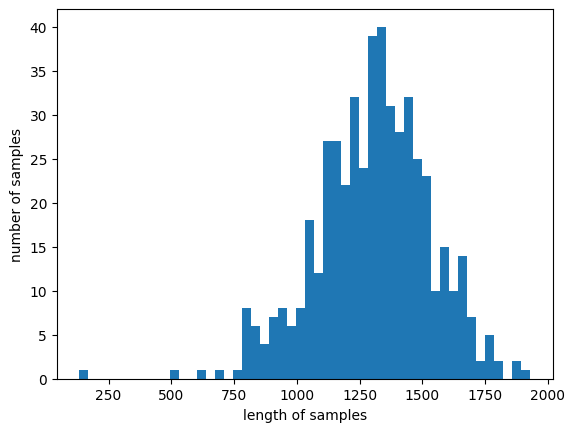

In [ ]:
documents = vectordb._collection.get()['documents']
print('문서의 개수 :', len(documents))
print('문서의 최대 길이 :',max(len(document) for document in documents))
print('문서의 최소 길이 :',min(len(document) for document in documents))
print('문서의 평균 길이 :',sum(map(len, documents))/len(documents))
plt.hist([len(review) for review in documents], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
input_text = "콜금리와 밀접한 관련이 있는 단기금리는 어떤게 있어"
chatbot_response = qa_chain(input_text)
chatbot_response

콜금리와 밀접한 관련이 있는 단기금리는 여러 가지가 있어! 주로 금융기관들 사이에서 단기 자금 거래에 사용되는 금리들이야. 몇 가지 예를 들어볼게:

1. **91일 만기 국채 수익률**: 정부가 발행하는 단기 국채의 수익률로, 콜금리가 오르면 이 금리도 같이 오르는 경향이 있어.

2. **단기금융증권 금리 (CP)**: 기업들이 단기 자금을 조달하기 위해 발행하는 상업어음(CP)의 금리야. 콜금리와 비슷하게 움직이는 경우가 많아.

3. **증권사 RP 금리**: 증권사가 발행하는 환매조건부채권의 금리로, 시장 상황에 따라 콜금리와 비슷한 방향으로 변동돼.

4. **CD(양도성예금증서) 금리**: 은행이 발행하는 양도성 예금 증서의 금리도 콜금리와 연동되는 경향이 있어.

이렇게 다양한 단기금리들이 콜금리와 연결되어 있어. 이 금리들은 금융시장의 유동성과 투자자들의 행동을 반영해서 계속 변동하거든. 혹시 더 궁금한 게 있으면, 예를 들어 '기준금리'에 대해서도 알아볼래? 기준금리도 금융시장에서 중요한 역할을 하거든!

{'query': '콜금리와 밀접한 관련이 있는 단기금리는 어떤게 있어',
 'result': "콜금리와 밀접한 관련이 있는 단기금리는 여러 가지가 있어! 주로 금융기관들 사이에서 단기 자금 거래에 사용되는 금리들이야. 몇 가지 예를 들어볼게:\n\n1. **91일 만기 국채 수익률**: 정부가 발행하는 단기 국채의 수익률로, 콜금리가 오르면 이 금리도 같이 오르는 경향이 있어.\n\n2. **단기금융증권 금리 (CP)**: 기업들이 단기 자금을 조달하기 위해 발행하는 상업어음(CP)의 금리야. 콜금리와 비슷하게 움직이는 경우가 많아.\n\n3. **증권사 RP 금리**: 증권사가 발행하는 환매조건부채권의 금리로, 시장 상황에 따라 콜금리와 비슷한 방향으로 변동돼.\n\n4. **CD(양도성예금증서) 금리**: 은행이 발행하는 양도성 예금 증서의 금리도 콜금리와 연동되는 경향이 있어.\n\n이렇게 다양한 단기금리들이 콜금리와 연결되어 있어. 이 금리들은 금융시장의 유동성과 투자자들의 행동을 반영해서 계속 변동하거든. 혹시 더 궁금한 게 있으면, 예를 들어 '기준금리'에 대해서도 알아볼래? 기준금리도 금융시장에서 중요한 역할을 하거든!",
 'source_documents': [Document(metadata={'source': '시사경제용어사전_45'}, page_content='콜금리와 밀접한 관련이 있는 단기금리는 무엇이 있나요?\n콜금리와 밀접한 관련이 있는 단기금리는 주로 다음과 같습니다:\n\n1. **기타 단기금리**: 콜금리와 유사한 방식으로 결정되는 단기금리로는 \n   - **91일 만기 국채 수익률**: 정부가 발행하는 단기 국채의 수익률로, 일반적으로 콜금리가 상승하면 이자율도 상승하는 경향이 있습니다.\n   - **단기금융증권 금리 (CP)**: 기업이 단기 자금을 조달하기 위해 발행하는 상업어음(CP)의 금리로, 콜금리와 밀접하게 연관되어 있습니다.\n   - **증권사 RP 금리**: 증권사가 발행하는 환매조건부채권의 금리로, 시장 

In [ ]:
input_text = "콜금리와 밀접한 관련이 있는 단기이자는 어떤게 있어"
chatbot_response = qa_chain(input_text)
chatbot_response

콜금리와 밀접한 관련이 있는 단기이자는 여러 가지가 있어! 주로 금융기관들 사이에서 단기 자금 거래에 사용되는 금리들이야. 몇 가지 예를 들어볼게:

1. **91일 만기 국채 수익률**: 정부가 발행하는 단기 국채의 수익률로, 콜금리가 오르면 이 금리도 오르는 경향이 있어.

2. **단기금융증권 금리 (CP)**: 기업들이 단기 자금을 조달하기 위해 발행하는 상업어음(CP)의 금리야. 콜금리와 비슷하게 움직이는 경우가 많아.

3. **증권사 RP 금리**: 증권사가 발행하는 환매조건부채권의 금리로, 시장 상황에 따라 콜금리와 비슷한 방향으로 변동돼.

4. **CD(양도성예금증서) 금리**: 은행이 발행하는 양도성 예금 증서의 금리도 콜금리와 연동되는 경향이 있어.

이런 단기금리들은 금융시장의 유동성과 경제 상황에 따라 민감하게 반응해. 그래서 콜금리와 함께 살펴보면 경제 동향을 이해하는 데 큰 도움이 될 거야!

혹시 더 궁금한 게 있으면, 예를 들어 '기준금리'나 '인플레이션' 같은 다른 경제 용어에 대해서도 물어봐!

{'query': '콜금리와 밀접한 관련이 있는 단기이자는 어떤게 있어',
 'result': "콜금리와 밀접한 관련이 있는 단기이자는 여러 가지가 있어! 주로 금융기관들 사이에서 단기 자금 거래에 사용되는 금리들이야. 몇 가지 예를 들어볼게:\n\n1. **91일 만기 국채 수익률**: 정부가 발행하는 단기 국채의 수익률로, 콜금리가 오르면 이 금리도 오르는 경향이 있어.\n\n2. **단기금융증권 금리 (CP)**: 기업들이 단기 자금을 조달하기 위해 발행하는 상업어음(CP)의 금리야. 콜금리와 비슷하게 움직이는 경우가 많아.\n\n3. **증권사 RP 금리**: 증권사가 발행하는 환매조건부채권의 금리로, 시장 상황에 따라 콜금리와 비슷한 방향으로 변동돼.\n\n4. **CD(양도성예금증서) 금리**: 은행이 발행하는 양도성 예금 증서의 금리도 콜금리와 연동되는 경향이 있어.\n\n이런 단기금리들은 금융시장의 유동성과 경제 상황에 따라 민감하게 반응해. 그래서 콜금리와 함께 살펴보면 경제 동향을 이해하는 데 큰 도움이 될 거야!\n\n혹시 더 궁금한 게 있으면, 예를 들어 '기준금리'나 '인플레이션' 같은 다른 경제 용어에 대해서도 물어봐!",
 'source_documents': [Document(metadata={'source': '시사경제용어사전_45'}, page_content='콜금리와 밀접한 관련이 있는 단기금리는 무엇이 있나요?\n콜금리와 밀접한 관련이 있는 단기금리는 주로 다음과 같습니다:\n\n1. **기타 단기금리**: 콜금리와 유사한 방식으로 결정되는 단기금리로는 \n   - **91일 만기 국채 수익률**: 정부가 발행하는 단기 국채의 수익률로, 일반적으로 콜금리가 상승하면 이자율도 상승하는 경향이 있습니다.\n   - **단기금융증권 금리 (CP)**: 기업이 단기 자금을 조달하기 위해 발행하는 상업어음(CP)의 금리로, 콜금리와 밀접하게 연관되어 있습니다.\n   - **증권사 RP 금리**: 증권사가 발행하는 환매조건부채권의 금리

In [ ]:
input_text = "24년 3월달의 전국 아파트 가격을 알려주세요"
chatbot_response = qa_chain(input_text)
chatbot_response

이건 내가 잘 모르는 내용이야. 다른 자료를 참고해보는 게 좋을 것 같아! 아파트 가격은 지역과 시기에 따라 크게 달라질 수 있으니, 최신 부동산 관련 사이트나 통계 자료를 확인해보는 게 좋을 거야. 혹시 부동산 시장에 대해 더 궁금한 게 있으면 언제든지 물어봐! 예를 들어, "부동산 버블"이나 "주택담보대출" 같은 용어에 대해 설명해줄 수도 있어.

{'query': '24년 3월달의 전국 아파트 가격을 알려주세요',
 'result': '이건 내가 잘 모르는 내용이야. 다른 자료를 참고해보는 게 좋을 것 같아! 아파트 가격은 지역과 시기에 따라 크게 달라질 수 있으니, 최신 부동산 관련 사이트나 통계 자료를 확인해보는 게 좋을 거야. 혹시 부동산 시장에 대해 더 궁금한 게 있으면 언제든지 물어봐! 예를 들어, "부동산 버블"이나 "주택담보대출" 같은 용어에 대해 설명해줄 수도 있어.',
 'source_documents': [Document(metadata={'source': '시사경제용어사전_631'}, page_content='잠정주택판매지수를 분석할 때 유의해야 할 점은 무엇인가요?\n잠정주택판매지수(Pending Home Sales Index)는 주택 시장의 건전성을 나타내는 중요한 지표 중 하나입니다. 이는 매매가 완료되지 않은, 즉 거래가 이루어지기로 합의된 주택 판매 계약 건수를 기준으로 하여 측정되며, 주택 시장의 미래 활동을 예측하는 데 활용됩니다. 다음은 이 지수를 분석할 때 유의해야 할 몇 가지 주요 사항입니다:\n\n1. **계절적 변동성**: 주택 판매는 계절에 따라 크게 영향을 받을 수 있습니다. 예를 들어, 겨울철에는 주택 판매가 감소하는 경향이 있습니다. 따라서, 지수를 분석할 때 계절적 변동성을 고려하여 연간 변경률을 비교하는 것이 중요합니다.\n\n2. **과거 데이터와의 비교**: 단기적인 변화가 의미 있는지 판단하기 위해 과거 데이터와의 비교를 통해 추세를 파악해야 합니다. 예를 들어, 현재 지수가 이전 몇 개월 또는 년도의 동일한 시점과 어떻게 비교되는지를 분석하는 것이 중요합니다.\n\n3. **지역별 분석**: 주택 시장은 지역마다 큰 차이를 보일 수 있습니다. 따라서 국가 전체의 지수를 분석하는 것뿐만 아니라 특정 지역, 주 또는 도시에서의 지수도 분석하여 지역적 요인을 반영해야 합니다.\n\n4. **경제적 배경**: 주택 시장은 경제 전반의 흐름과 긴밀하게 

# Demo Chatbot

In [ ]:
# !pip install gradio==3.50.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 78.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.6/130.6 kB 13.6 MB/s eta 0:00:00
  Attempting uninstall: websockets
    Found existing installation: websockets 14.2
    Uninstalling websockets-14.2:
      Successfully uninstalled websockets-14.2
  Attempting uninstall: pillow
    Found existing installation: pillow 11.1.0
    Uninstalling pillow-11.1.0:
      Successfully uninstalled pillow-11.1.0
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-genai 0.8.0 

In [ ]:
import gradio as gr

def respond(message, chat_history):
    result = qa_chain(message)
    bot_message = result['result']
    chat_history.append((message, bot_message))
    return "", chat_history

with gr.Blocks(css=".gradio-container {max-width: 600px; margin: auto;}") as demo:
    gr.Markdown("""<h2 style='text-align: center;'>📖 시사경제용어사전</h2>""")
    chatbot = gr.Chatbot(height=700, show_label=False)
    msg = gr.Textbox(placeholder="질문을 입력하세요...", label="")
    with gr.Row():
        clear = gr.Button("🔄 초기화", size="sm")

    msg.submit(respond, [msg, chatbot], [msg, chatbot])
    clear.click(lambda: None, None, chatbot, queue=False)

demo.launch(debug=True)


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
IMPORTANT: You are using gradio version 3.50.2, however version 4.44.1 is available, please upgrade.
--------
Running on public URL: https://d3c8f400f9edf2b413.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


콜금리와 밀접한 관련이 있는 단기이자는 여러 가지가 있어! 주로 금융기관들 사이에서 단기 자금 거래에 사용되는 금리들이야. 몇 가지 예를 들어볼게:

1. **91일 만기 국채 수익률**: 정부가 발행하는 단기 국채의 수익률로, 콜금리가 오르면 이 금리도 오르는 경향이 있어.

2. **단기금융증권 금리 (CP)**: 기업들이 단기 자금을 조달하기 위해 발행하는 상업어음(CP)의 금리야. 콜금리와 밀접하게 연관되어 있어.

3. **증권사 RP 금리**: 증권사가 발행하는 환매조건부채권의 금리로, 시장 상황에 따라 콜금리와 비슷한 방향으로 변동돼.

4. **CD(양도성예금증서) 금리**: 은행이 발행하는 양도성 예금 증서의 금리도 콜금리와 연동되는 경향이 있어.

이런 단기금리들은 금융시장의 유동성과 경제 상황에 따라 변동하기 때문에, 콜금리와 함께 살펴보면 경제 동향을 이해하는 데 큰 도움이 돼!

혹시 더 궁금한 게 있으면, 예를 들어 "기준금리"나 "인플레이션" 같은 다른 경제 용어에 대해서도 물어봐!콜금리와 밀접한 관련이 있는 단기금리는 여러 가지가 있어! 주로 금융기관들 사이에서 단기 자금 거래에 사용되는 금리들이야. 몇 가지 예를 들어볼게:

1. **91일 만기 국채 수익률**: 정부가 발행하는 단기 국채의 수익률로, 콜금리가 오르면 이 금리도 같이 오르는 경향이 있어.

2. **단기금융증권 금리 (CP)**: 기업들이 단기 자금을 조달하기 위해 발행하는 상업어음(CP)의 금리야. 콜금리와 비슷하게 움직이는 경우가 많아.

3. **증권사 RP 금리**: 증권사가 발행하는 환매조건부채권의 금리로, 시장 상황에 따라 콜금리와 비슷한 방향으로 변동돼.

4. **CD(양도성예금증서) 금리**: 은행이 발행하는 양도성 예금 증서의 금리도 콜금리와 연동되는 경향이 있어.

이렇게 다양한 단기금리들이 콜금리와 연결되어 있어. 이 금리들은 금융시장의 유동성과 투자자들의 행동을 반영해서 계속 변동하거든. 혹시 더 궁금한 게 있으면, 예를 들어 '기준금리'에

## 유사어 사전을 적용함으로써 동일한 문서 검색이 가능한 모습

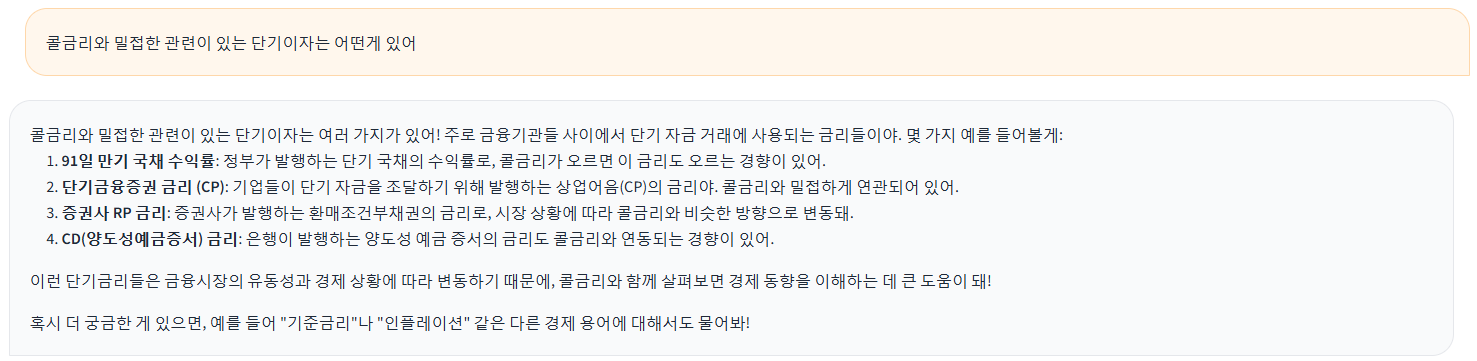

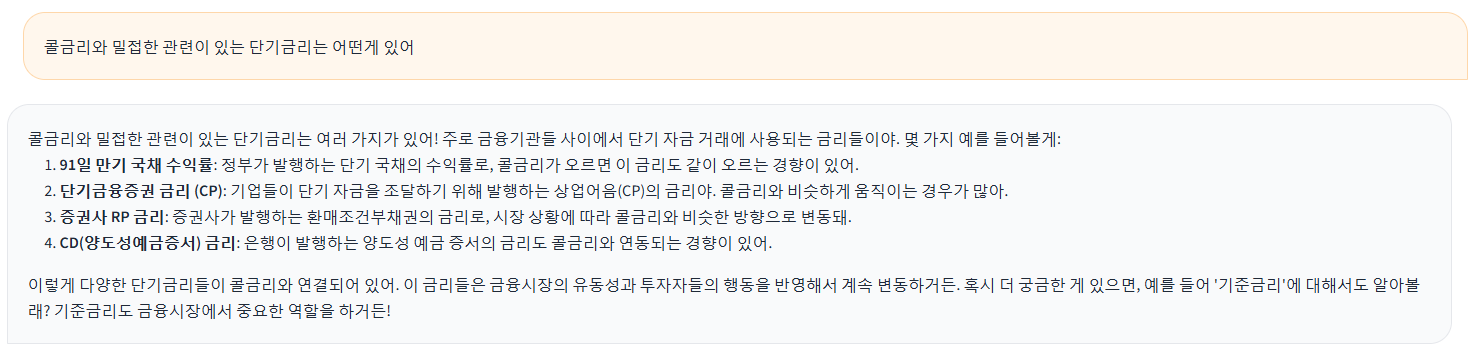

## Data에 없는 내용을 검색하니 Prompt 내용대로 문서에서 검색 할 수 없는 내용이라고  언급       

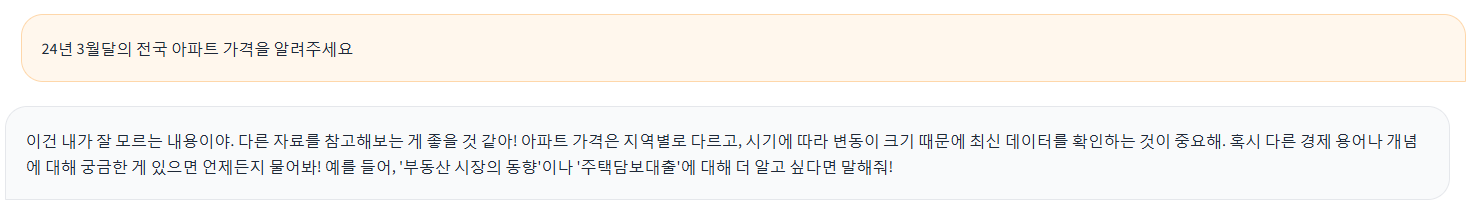